# Downloading data cubes from the Web Map Service

With the help of requests this script allows the user to download whole timeseries of data (Sentinel 1, 2 and 3) for a certain longitude/latitude combination.

In [1]:
import requests
import json
from PIL import Image
import io
import numpy as np
from urllib.parse import urlsplit, parse_qs
from pprint import pprint
from time import time
from pyproj import Proj, transform

First, the user has to specify the desired lon/lat as well as number of pixels per dimension and the resolution of the image.

In [ ]:
# specify central lon/lat of the image as well as dimension
lon = -101.
lat = -75.0
xdim = 1920 # number of pixels per dimension
ydim = 1080 
reso = 180 # meters

Following now are some cells to specify different parameters, such as Satellite of interest, layer (e.g. true color, NDVI etc.) and maximum cloud cover (called maxcc, if commented out, the max cloud cover will be ignored in the request). The data will be downloaded from the WMS from Sinergise. The data is stored on the Earth Observation Innovative Platform Testbed Poland (EO IPT Poland, www.cloudferro.com/en/eocloud/). The WMS instance has to be configurated (i.e. the user's ID is requested) by the user beforehand for which an account is required (www.sinergise.com).

In [47]:
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3857')
xC,yC = transform(inProj,outProj, lon, lat)
xmin = xC - xdim*reso/2
xmax = xC + xdim*reso/2
ymin = yC - ydim*reso/2
ymax = yC + ydim*reso/2

ID = 'insert your ID'
URL = 'http://services.eocloud.sentinel-hub.com/v1/wms/'+ID

params = {'service': 'WMS',
          'request': 'GetMap',
          'layers': 'S1_HV',
          'styles': '',
          'format': 'image/png',
          'transparent': 'false',
          'version': '1.1.1',
          'showlogo': 'false',
          'height': ydim,
          'width': xdim,
          #'maxcc': 20,
          #'time': '2017-10-12',
          'srs': 'EPSG%3A3857', 
          'bbox': str(xmin)+', '+str(ymin)+', '+str(xmax)+', '+str(ymax)
         }

check if the covered area or the chosen layer etc. are satisfactory

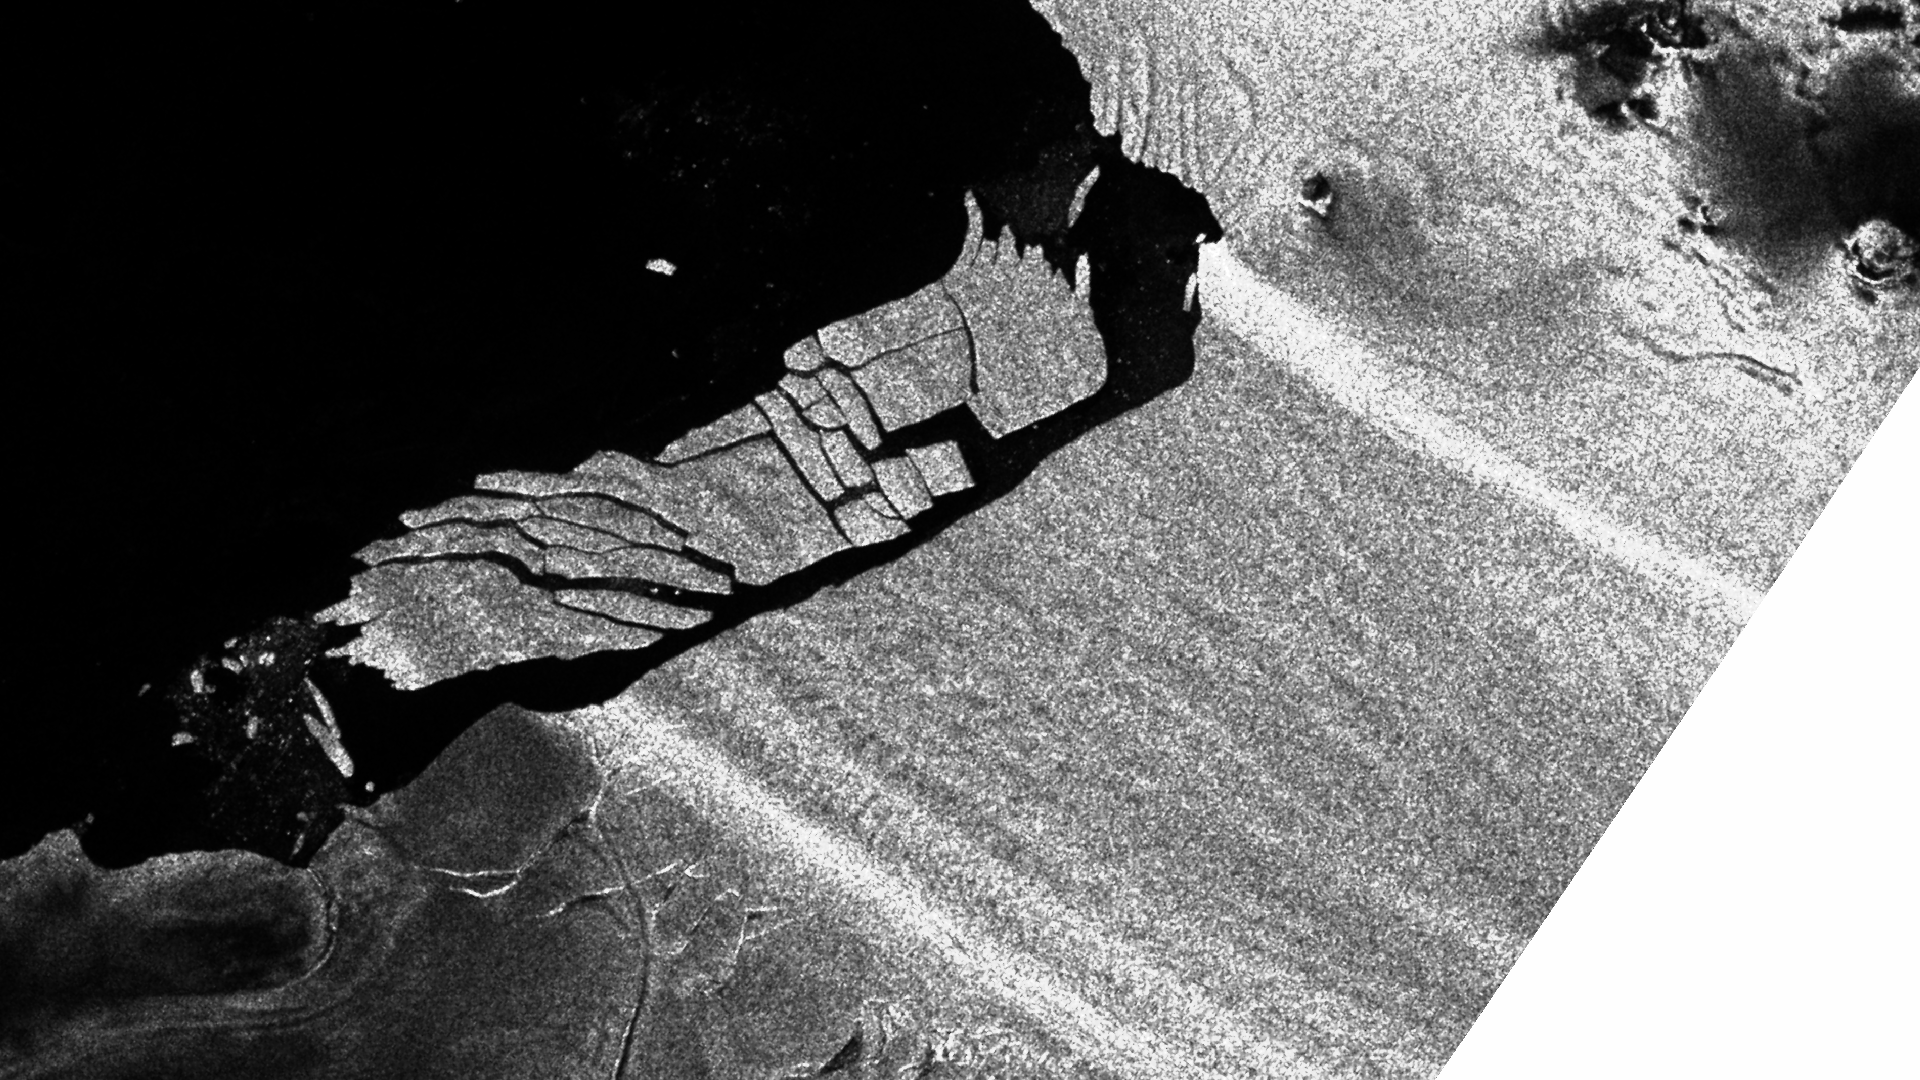

In [48]:
r = requests.get(URL, {**params})
imgTiff = None
try:
    imgTiff = Image.open(io.BytesIO(r.content))
except:
    print(r.url)
imgTiff

with the EO Data Finder check for available dates. Parameters such as 'processingLevel' depend on the chosen satellite and can be looked up here: https://finder.eocloud.eu/www/

In [38]:
EOCURL = 'https://finder.eocloud.eu/resto/api/collections/Sentinel1/search.json'
params_eocurl = {'dataset': 'ESA-DATASET',
                 'lat': str(lat),
                 'lon': str(lon),
                 'maxRecords': 1000,
                 #'processingLevel': 'LEVEL1B',
                 #'cloudCover': '[0,20]',
                 'sortOrder': 'descending',
                 'sortParam': 'startDate'
                }

In [39]:
r1 = requests.get(EOCURL, params_eocurl)
#print(r1.url)
js = json.loads(r1.content)
try:
    num_features = len(js['features'])
    print(f'# products: {num_features}')
except:
    print(r1.url)
    print('Cannot read response')

# products: 597


In [40]:
products = []
dummy = None
for j in js['features']:
    day = j['properties']['startDate'].split('T')[0]
    products.append((day, j))

 # days: 597


the actual download:

In [41]:
res = []
starttime = time()
fail = 0
for i, (day, j) in enumerate(products):
    print(f'{i}/{len(products)} loading', end='\r')
    r = requests.get(URL, {**params, **{'time': f'{day}/{day}'}})

    try:
        res.append((day, np.array(Image.open(io.BytesIO(r.content)))))
        print(f'{i}/{len(products)} success')
    except Exception as e:
        print(f'{i}/{len(products)} failure')
        fail += fail
        
        #print(r.url)
endtime = time()
duration = (endtime - starttime)/60
print(f'{duration} minutes,', f'{fail} failed')

0/597 success
1/597 success
2/597 success
3/597 success
4/597 success
5/597 success
6/597 success
7/597 success
8/597 success
9/597 success
10/597 success
11/597 success
12/597 success
13/597 success
14/597 success
15/597 success
16/597 success
17/597 success
18/597 success
19/597 success
20/597 success
21/597 success
22/597 success
23/597 success
24/597 success
25/597 success
26/597 success
27/597 success
28/597 success
29/597 success
30/597 success
31/597 success
32/597 success
33/597 success
34/597 success
35/597 success
36/597 success
37/597 success
38/597 success
39/597 success
40/597 success
41/597 success
42/597 success
43/597 success
44/597 success
45/597 success
46/597 success
47/597 success
48/597 success
49/597 success
50/597 success
51/597 success
52/597 success
53/597 success
54/597 success
55/597 success
56/597 success
57/597 success
58/597 success
59/597 success
60/597 success
61/597 success
62/597 success
63/597 success
64/597 success
65/597 success
66/597 success
67/59

# saving section

used to save all the downloaded data for further use. it will not be loaded in this notebook but the actual response from the request will be used for plotting and saving the images

In [42]:
ts2 = []
if lon <= 0:
    lon = str(lon+360)+'E'
else:
    lon = str(lon)+'E'
if lat <= 0:
    lat = str(-lat)+'S'
else:
    lat = str(lat)+'N'
for i in range(len(res)):
    ts2.append(res[i][1])
layer = params['layers']
name = 'S1_LARSEN'
np.save(f'Data/{name}_{layer}_{lon}_{lat}', np.array(ts2))

In [43]:
ts2 = []
for i in range(len(res)):
    ts2.append(res[i][0])
np.save(f'Data/{name}_{layer}_{lon}_{lat}_days', np.array(ts2))